In [259]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import jax.numpy as jnp
from jax import grad
from matplotlib.colors import LogNorm

In [260]:
def rho(x,y,z,e,p,q,rho0,s,a,b):
    """
    Calculate density value based on input coordinates and parameters.

    Parameters:
    x (float or array-like): x-coordinate(s) of the point(s).
    y (float or array-like): y-coordinate(s) of the point(s).
    z (float or array-like): z-coordinate(s) of the point(s).
    e (float): Parameter describing the disky/boxiness of the triaxial body.
    p (float): Axis ratio b/a.
    q (float): Axis ratio c/a.
    rho0 (float): Normalization parameter for density.
    s (float): Scale radius.
    a (float): Power-law exponent.
    b (float): Power-law exponent.

    Returns:
    float or array-like: Density value(s) at the given coordinates.

    Formula:
    The function calculates density value(s) based on the input coordinates (x, y, z) and parameters (e, p, q, rho0, s, a, b)
    using the following formula:

        r = ((|x|^(2 - e) + (|y| / p)^(2 - e) + (|z| / q)^(2 - e)))^(1/(2-e))
        rho = rho0 / ((r / s)^a * (1 + (r / s))^(b - a))

    where:
        |x|, |y|, |z|: Absolute values of the coordinates.
        e: Exponent parameter.
        p, q: Scaling parameters for x and y coordinates.
        rho0: Normalization parameter for density.
        s: Scaling parameter for distance.
        a, b: Shape parameters.
        r: Distance metric calculated based on the input coordinates.
        rho: Density value calculated based on the input parameters and coordinates.
    """
    r = ((jnp.abs(x)**(2 - e) + (jnp.abs(y) / p)**(2 - e) + (jnp.abs(z) / q)**(2 - e)))**(1/(2-e))
    den = rho0 / ((r/s)**a*(1+(r/s))**(b-a))
    #den = np.round(den, decimals=6)
    return den

In [261]:
def projection(density_mat):
    """
    Returns the 2D projection of a 3D density matrix along the z-axis.

    Parameters:
    - density_mat (numpy.ndarray): The 3D density matrix representing the density distribution.
                                   The shape of the matrix should be (M, N, K), where M, N, and K
                                   are the dimensions along the x, y, and z axes respectively.

    Returns:
    float or array-like: Projected Density value(s) along the z-axis.

    This function calculates the projection of the given density matrix along the z-axis,
    summing up the values along the z-axis to produce a 2D array. 
    """
    projection_z_axis = jnp.sum(density_mat, axis = 2)
    return projection_z_axis


In [262]:
def plot_img_logscale(proj_density_mat):
    """
    Plot a 2D image with a logarithmically scaled colour bar.

    Parameters:
    - proj_density_mat (numpy.ndarray): The 2D density matrix representing the density distribution projected along the z-axis.
                                   

    Returns:
    None

    This function uses Plotly matplotlib
    to create and display an image plot of the projected density with a logarithmically scaled colour bar..
    """
    plt.imshow(proj_density_mat, norm=colors.LogNorm(vmin=proj_density_mat.min(), vmax=proj_density_mat.max()), origin='lower')
    plt.colorbar(label='Color Scale (log)')
    plt.show()

In [263]:
s = 1 
e = 0
p = 0.8
q = 0.6
a = 2
b = 4
rho0 = 0.001


# Define the size of your 3D matrix
x_size, y_size, z_size = 10, 10, 10

# Create 3D coordinates
x, y, z = np.meshgrid(np.linspace(-0.01, 0.01, x_size),
                      np.linspace(-0.01, 0.01, y_size),
                      np.linspace(-0.01, 0.01, z_size),  indexing='ij')

#x = np.round(x, decimals=10)
#y = np.round(y, decimals=10)
#z = np.round(z, decimals=10)


#pos_ar = np.array([x.flatten(),y.flatten(),z.flatten()])
density_true = rho(x.flatten(),y.flatten(),z.flatten(),e,p,q,rho0,s,a,b)
density_true = density_true.reshape((x_size,y_size,z_size))
proj_density_true = projection(density_true)

In [264]:
def chi_sq(image1, image2, sigma):
    """
    Compute Sum of Squared Differences (SSD) between two images.
    
    Args:
    - image1: numpy array representing the first image
    - image2: numpy array representing the second image
    
    Returns:
    - ssd_value: sum of squared differences between the two images
    """
    # Ensure images have the same shape
    if image1.shape != image2.shape:
        raise ValueError("Images must have the same dimensions")
    
    # Calculate SSD
    ssd_value = jnp.sum(((image1 - image2)/sigma)**2)
    
    return ssd_value

In [265]:
p_test = np.linspace(0.1, 1, 100)  
q_test = np.linspace(0.1, 1, 100)
sigma = 1
score = np.zeros((len(p_test),len(q_test)))


for i in range(len(p_test)):
    for j in range(len(q_test)):
        density_test = rho(x.flatten(),y.flatten(),z.flatten(),e,p_test[i],q_test[j],rho0,s,a,b)
        density_test = density_test.reshape((x_size,y_size,z_size))
        proj_density_test = projection(density_test)
        score[i,j] = chi_sq(proj_density_true, proj_density_test, sigma)






In [266]:
from jaxopt import ScipyBoundedMinimize

In [273]:
def chi_sq_for_minimize(params,args):
    x_in, y_in, z_in, true_image, sigma = args

    
    p = params[0]
    q = params[1]


    rho_test = rho(x_in, y_in, z_in, e, p, q, rho0, s, a, b)
    rho_test = rho_test.reshape((x_size,y_size,z_size))
    test_image = projection(rho_test)
    # Calculate SSD
    ssd_value = np.sum(((true_image - test_image)/sigma)**2)

    
    
    return ssd_value

In [278]:

bounds = [(0.1, 0.1), (1., 1.)]

initial_guess = [0.1, 0.1]
x_in = x.flatten()
y_in = y.flatten()
z_in = z.flatten()
true_image = proj_density_true
sigma = 1.

params_history = []

def callback(xk):
    # Save the parameters at each step
    params_history.append(xk)

optimizer = ScipyBoundedMinimize(fun = chi_sq_for_minimize, method='L-BFGS-B', callback=callback)

result = optimizer.run(initial_guess,args=(x_in,y_in,z_in,true_image,sigma), bounds = bounds)


In [279]:
params = [[0.1, 0.1]]
for i in range(len(params_history)):
    param_tup = []
    for j in range(2):
        val = float(params_history[i][j])
        param_tup.append(val)
    params.append(param_tup)
params  = np.array(params)

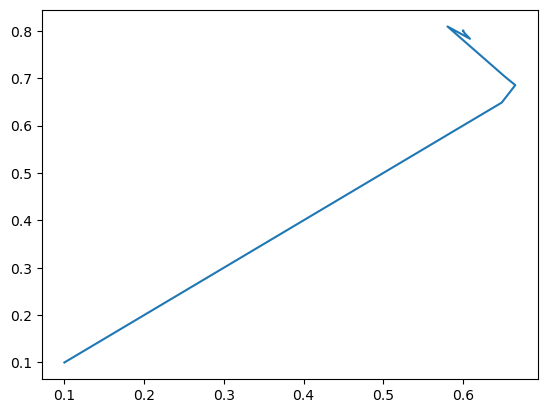

In [280]:
plt.plot(params[:,1],params[:,0])

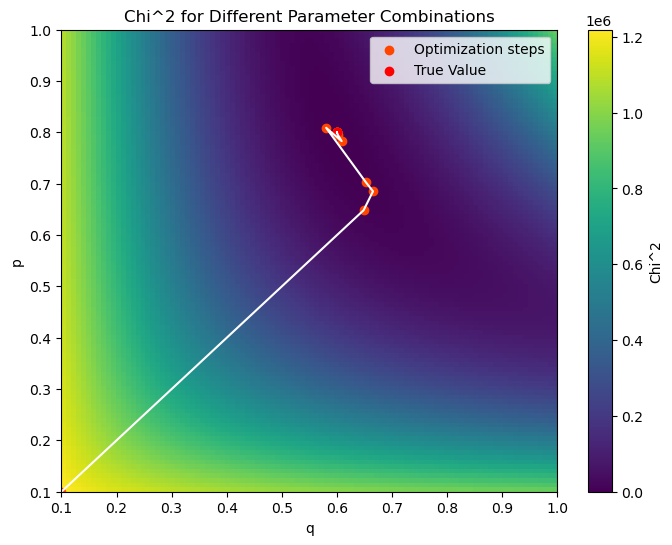

In [286]:
plt.figure(figsize=(8, 6))
plt.imshow(score,extent=[q_test.min(), q_test.max(), p_test.min(), p_test.max()],  origin='lower', aspect='auto') 
plt.colorbar(label='Chi^2')
plt.yticks(np.linspace(p_test.min(), p_test.max(), 10))  # Specify x-axis ticks
plt.xticks(np.linspace(q_test.min(), q_test.max(), 10))  # Specify y-axis ticks
plt.xlabel('q')
plt.ylabel('p')
plt.title('Chi^2 for Different Parameter Combinations')

true_value_q = 0.6  # Example true value for param1
true_value_p = 0.8  # Example true value for param2

plt.plot(params[:,1],params[:,0], color = 'white')
plt.scatter(params[:,1],params[:,0],color='orangered', label='Optimization steps')
plt.scatter(true_value_q, true_value_p, color='red', label='True Value')
plt.legend()
#plt.grid(True)
plt.show()


In [287]:
params

array([[0.1       , 0.1       ],
       [0.64836454, 0.64836454],
       [0.68520802, 0.66538447],
       [0.7026034 , 0.65264326],
       [0.80894905, 0.58035219],
       [0.78300005, 0.60856634],
       [0.79469335, 0.6019361 ],
       [0.79967535, 0.59991723],
       [0.79997474, 0.59997958],
       [0.80000013, 0.60000002],
       [0.80000001, 0.59999996],
       [0.80000007, 0.59999996]])